In [1]:
import itertools
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats.distributions as distr

from cyber import Defence, CommmonDefences, CyberComponent
from tree import TreeNode, Link
from comm_network import Aggregator, Device, CommNetwork

In [2]:
from comm_network import LevelOfRedundancy
seed = np.random.randint(low=0, high=52600)
seed = 27194
print(f"Seed: {seed}")
np.random.seed(seed)
pcn = CommNetwork(n_devices=5, n_entrypoints=3, redundancy=3, redundancy_deviation=2, enable_sibling_to_sibling_comm=True)
root = pcn.root
print(CommNetwork.show_tree(root))
tree = pcn.graph
print(f"Number of Components: {pcn.n_components}")

Seed: 27194
Aggregator(id=8, is_accessible=False)
   Aggregator(id=5, is_accessible=True)
      Device(id=0, is_controller=False, is_autonomous=False, is_sensor=True, is_accessible=True)
   Aggregator(id=6, is_accessible=True)
      Device(id=1, is_controller=True, is_autonomous=False, is_sensor=True, is_accessible=False)
      Device(id=2, is_controller=False, is_autonomous=False, is_sensor=True, is_accessible=False)
   Aggregator(id=7, is_accessible=False)
      Device(id=4, is_controller=False, is_autonomous=False, is_sensor=True, is_accessible=False)
      Device(id=3, is_controller=False, is_autonomous=False, is_sensor=True, is_accessible=False)

Number of Components: 9


In [ ]:
from attackers import RandomAttacker
attacker = RandomAttacker(budget=52, verbose=True)
attacker.attack_network(pcn)

In [ ]:
import itertools

def analyze_network(root:Aggregator, compromise_probabilities={}, devices_seen=0):
    """
    Assumes the Control Center is the only entry point (and has already been compromised).


    Args:
        comm_network (CommNetwork): _description_
        probability_threshold (_type_, optional): _description_. Defaults to np.linspace(0, 1, 100).
    """
    time_required = 0.0
    for child in root.children:
        prob_to_compromise = 1.0
        for defence in child.defences.values():
            time_required += defence.effort_distribution.expect()
            prob_to_compromise *= defence.p
        compromise_probabilities[1] = None
        devices_seen += 1

    # nodes = comm_network.graph.nodes()
    # node_probs = {}
    # for node in nodes:
    #     print(node)
    #     probability_to_compromise = 1.0
    #     for defence_name, defence in node.defences.items():
    #         expected_effort = defence.effort_distribution.expect()
    #         time_required += expected_effort
    #         print("\t", defence_name)
    #         probability_to_compromise *= defence.p
    #     node_probs[node] = probability_to_compromise
    # print(node_probs)
    # prob_to_compromise_n_devices = {}
    # all_nodes = set(nodes)
    # cumulative = 0.0
    # for n_devices in range(comm_network.n_components, 0, -1):
    #     prob_to_compromise_n_devices[n_devices] = cumulative
    #     for combination in itertools.combinations(nodes, n_devices):
    #         probability_to_compromise = 1.0
    #         combination = set(combination)
    #         missing_nodes = all_nodes.difference(combination)
    #         for node in combination:
    #             probability_to_compromise *= node_probs[node]
    #         for node in missing_nodes:
    #             probability_to_compromise *= (1 - node_probs[node])
    #         prob_to_compromise_n_devices[n_devices] += probability_to_compromise 
    #     print(f"{n_devices}: {prob_to_compromise_n_devices[n_devices]}")
    #     cumulative += prob_to_compromise_n_devices[n_devices]
    # print(prob_to_compromise_n_devices)
analyze_network(pcn)

In [ ]:
# Takes: 12.6 µs
N = pcn.n_components
k = 2
p = 0.5
cumulative = 0.0
for k in range(pcn.n_components, 0, -1):
    prob = math.comb(N, k)*math.pow(p, k)*math.pow(1-p,N-k)
    print(f"{k}: {cumulative + prob}")
    cumulative += prob

In [ ]:
import multiprocessing as mp
from multiprocessing import Process, Pool


def combinations(iterable, k):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if k > n:
        return
    indices = list(range(k))
    yield tuple(pool[i] for i in indices), tuple(pool[i] for i in range(k, n)), k
    while True:
        for i in reversed(range(k)):
            if indices[i] != i + n - k:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, k):
            indices[j] = indices[j-1] + 1
        neg_indices = tuple(pool[i] for i in range(n) if i not in indices)
        yield tuple(pool[i] for i in indices), neg_indices, k

def process_wrapper(successes, failures, k):
    prob = np.prod(successes)
    return prob + (np.prod(failures) if len(failures) >= 1 else 1.0), k

N = pcn.n_components
p = 0.5
np.random.seed(0)
ps = np.random.uniform(low=0, high=1, size=N)
ps = np.full(shape=N, fill_value=p)
idcs = np.arange(N)
all_idcs = set(idcs)
cumulative = 0.0
with Pool(processes=mp.cpu_count()-1) as pool:
    results = []
    for k in range(pcn.n_components, 0, -1):
        # k_prob = 0.0
        results.extend(pool.imap_unordered(process_wrapper, combinations(ps, k), chunksize=32))
print("Pool Active")
[result.wait() for result in results]
            # results = [pool.apply_async(process_wrapper, args=(successes, failures)) for successes, failures in combinations(ps, k)]
            # k_prob = sum([res.get(timeout=-1) for res in results])
                # # Succeses: p^k (where p is not fixed)
                # prob = np.prod(successes)
                # # Failures: (1-p)^(n-k) (where p is not fixed)
                # prob *= np.prod(failures) if len(failures) >= 1 else 1.0
            # k_prob += prob
        # print(f"{k}: {cumulative + k_prob}, {k_prob}")
        # cumulative += k_prob

In [ ]:
for permutation in itertools.permutations([0,1,2],3):
    print(permutation)

for combination in itertools.combinations([0,1,2],2):
    print(combination)

C:\Users\Xavier\AppData\Local\Temp\ipykernel_7484\4234236518.py:91: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tree, pos=tree_pos, ax=axes[0], edge_color=edge_color_mask)
C:\Users\Xavier\AppData\Local\Temp\ipykernel_7484\4234236518.py:99: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(tree, pos=spring_pos, ax=axes[1], edge_color=edge_color_mask)


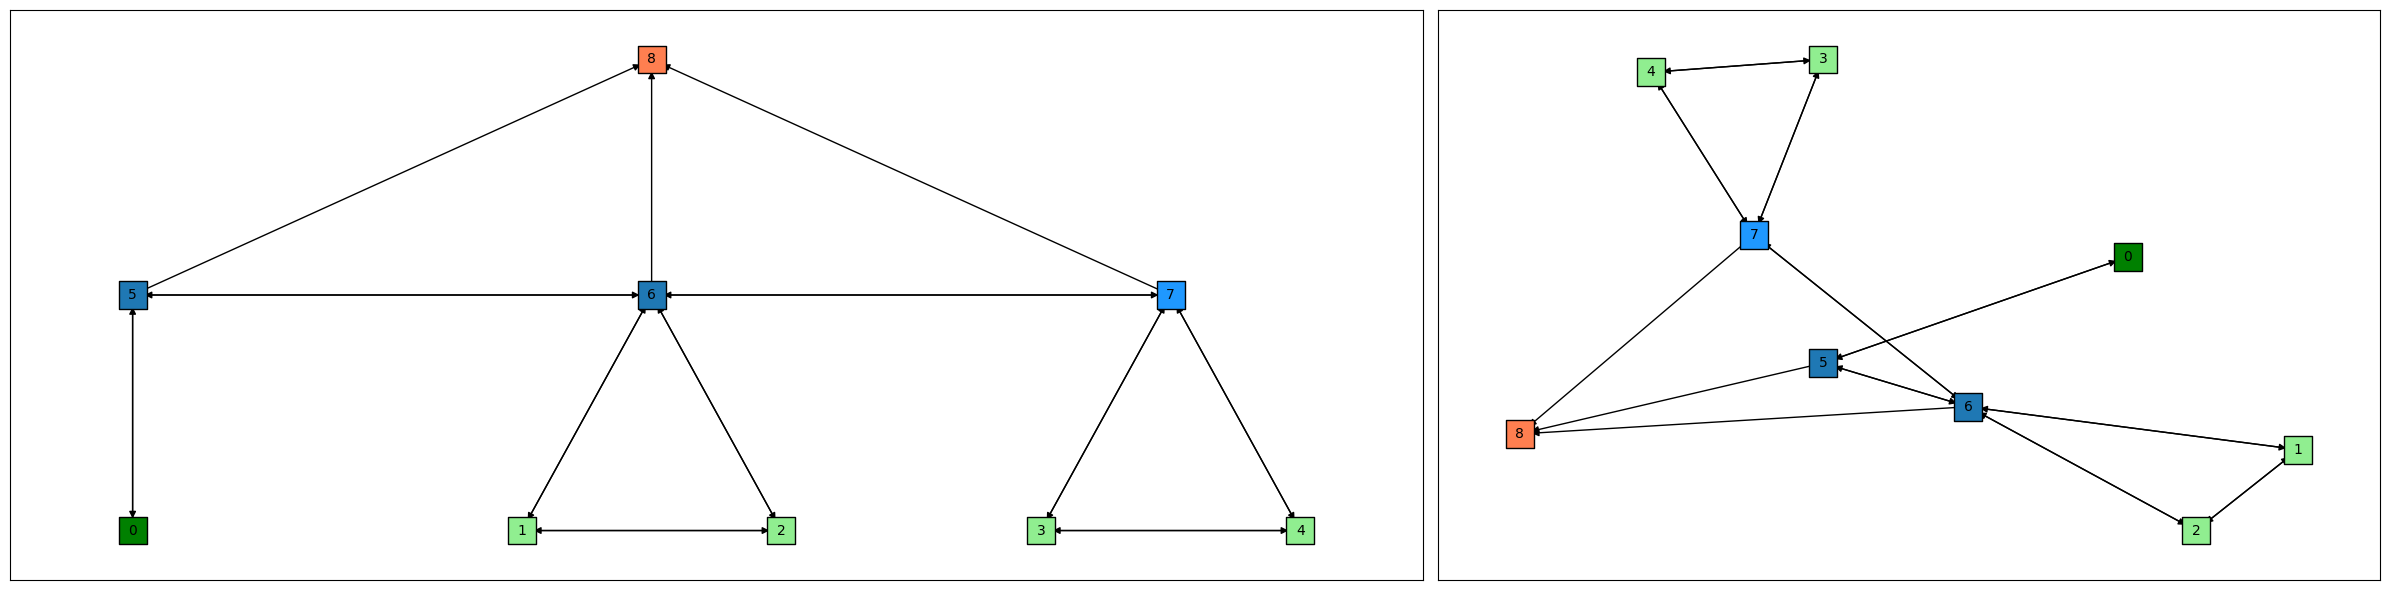

In [3]:
def hierarchy_pos(G:nx.DiGraph, root:TreeNode, width:float=1., vert_gap:float=0.2, vert_loc:float=0, xcenter:float=0.5):

    '''
    Credit: Joel (https://stackoverflow.com/a/29597209/2966723) 
    Licensed under CC Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G (networkx.DiGraph): Graph (must be a tree)
    root (Node): Root node of current graph
    width (float): Horizontal space allocated for this branch - avoids overlap with other branches. Defaults to 1.0
    vert_gap (float): Gap between levels of hierarchy. Defaults to 0.2
    vert_loc (float): Vertical location of root. Defaults to 0.0
    xcenter (float): Horizontal location of root. Defaults to 0.5
    '''
    # if not nx.is_tree(G):
    #     raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = np.random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = root.children # list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            for child in children:
                child.remove_parents(parent)  
        if len(children) !=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in sorted(children, key=lambda child:child.id):
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

node_color_mask = np.full(tree.number_of_nodes(), fill_value="#1f78b4", dtype=object)
node_edge_color_mask = np.full(tree.number_of_nodes(), fill_value="#000000", dtype=object)
edge_color_mask = np.full(tree.number_of_edges(), fill_value="#000000", dtype=object)
node_shape_mask = np.full(tree.number_of_nodes(), fill_value="s", dtype=object)
root_idx = None
for i, node in enumerate(tree.nodes()):
    if node.is_leaf:
        # Dark Green if the Leaf Node (Device) is an entry point
        node_color_mask[i] = "green" if node.is_accessible else "lightgreen"
    else:
        # Dark Blue if the Internal Node (Aggregator) is an entry point
        node_color_mask[i] = "#1f78b4" if node.is_accessible else "#1f98ff"
    # If the Node has no parent, it is the root of the Tree (the control center)
    if len(node.parents) == 0:
        root_idx = i
        node_color_mask[i] = "coral"
    if node.is_compromised:
        # Compromised/hacked nodes have a red outline around them
        node_edge_color_mask[i] = "#ff0000"

for j, (start_node, end_node) in enumerate(tree.edges()):
    # Edges / Communication Channels between 2 compromised nodes are compromised
    if start_node.is_compromised and end_node.is_compromised:
        edge_color_mask[j] = "#ff0000"

# >> Plotting <<
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(24,6), width_ratios=[0.6, 0.4])
label_map = {node:node.id for node in tree.nodes()}

# Hierarchical / Tree Visualization of Communication Network
tree_pos = hierarchy_pos(nx.to_undirected(tree), root)
nx.draw_networkx_nodes(tree, pos=tree_pos, ax=axes[0],
                       node_size=400, node_shape="s", node_color=node_color_mask,
                       linewidths=1.0, edgecolors=node_edge_color_mask)
nx.draw_networkx_labels(tree, pos=tree_pos, labels=label_map, ax=axes[0], font_size=10)
nx.draw_networkx_edges(tree, pos=tree_pos, ax=axes[0], edge_color=edge_color_mask)

# Spring Visualization of Communication Network
spring_pos = nx.layout.spring_layout(tree)
nx.draw_networkx_nodes(tree, pos=spring_pos, ax=axes[1],
                       node_size=400, node_shape="s", node_color=node_color_mask, 
                       linewidths=1.0, edgecolors=node_edge_color_mask, )
nx.draw_networkx_labels(tree, pos=spring_pos, labels=label_map, ax=axes[1], font_size=10)
nx.draw_networkx_edges(tree, pos=spring_pos, ax=axes[1], edge_color=edge_color_mask)
plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats.distributions as distr
distr_lookup = {
    "TruncNorm": distr.truncnorm, # Continuous, loc=mean (float), scale=standard deviation (float)
    "Exponential": distr.expon, # Continuous, scale = 1 / lambda (float)
    "Gamma": distr.gamma, # Continuous, a = shape parameter (integer)
    "Bernoulli": distr.bernoulli, # Discrete
}
n_attacks = 20
is_successful = distr.bernoulli(0.5).rvs(size=n_attacks).astype(bool)
time_taken = distr.expon(scale=0.0).rvs(size=n_attacks)[is_successful]
print(f"Successful Attacks {sum(is_successful)}/{n_attacks}\nTime Taken per Successful Attack: {time_taken}")